**Loading the dataset**

We'll start by loading the dataset, which contains reviews of food products on Amazon and their associated ratings.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving small_data.csv to small_data.csv


Here, we load the dataset into a pandas dataframe. 

In [0]:
import pandas as pd

for k in uploaded.keys():
  df = pd.read_csv(k, sep=',', quotechar='"')

(array([ 1803.,     0.,  1021.,     0.,     0.,  1481.,     0.,  2871.,
            0., 12824.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

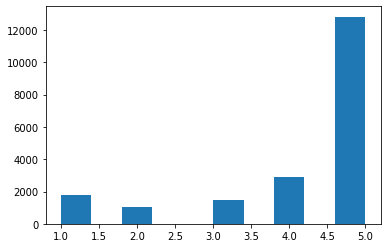

In [6]:
import matplotlib.pyplot as plt
plt.hist(df["Score"])

In [0]:
def extract_text(df):
    return [Soup(text, features="html.parser").get_text() for text in df["Text"]]

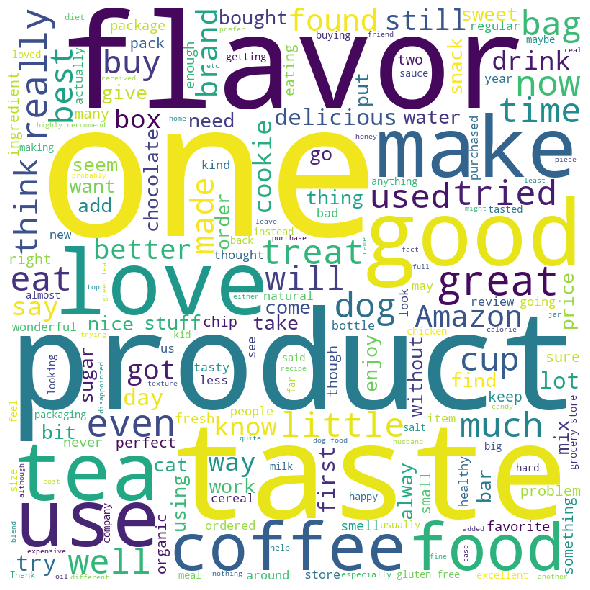

In [8]:
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup as Soup

stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate("\n".join(extract_text(df))) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# BERT model

BERT was our best performing model, so we will give a brief walkthrough to how we used it. We used the ktrain package to simplify training and use, so first we need to install ktrain:


In [7]:
!pip install ktrain
!pip install tensorflow-gpu==1.14

Let's also upload a balanced version of the dataset for use:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving small_data_balanced.csv to small_data_balanced (1).csv


Loading the data into a pandas dataframe:

In [0]:
import pandas as pd
from bs4 import BeautifulSoup as Soup

def extract_text(df):
    return [Soup(text, features="html.parser").get_text() for text in df["Text"]]

for k in uploaded.keys():
  df = pd.read_csv(k, sep=',', quotechar='"')

Now, let's define a BERT wrapper class:


In [0]:
import ktrain
from ktrain import text
import matplotlib.pyplot as plt
import tensorflow as tf

class BERT:
    def __init__(self, max_len = 320, batch_size = 14, lr = 2e-5, epochs = 3):
        self.model = None
        self.learner = None
        self.predictor = None
        self.max_len = max_len
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs

    def fit(self, train_strings, y_train, show_plot=False, verbose=True):
        tf.random.set_random_seed(0)
        (x_train, y_train), (x_test, y_test), preproc = \
            text.texts_from_array(train_strings, y_train, class_names=["low", "high"], preprocess_mode="bert", maxlen=self.max_len, lang="en")
        self.model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, verbose=verbose)
        learner = ktrain.get_learner(self.model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=self.batch_size)
        self.learner = learner
        learner.fit_onecycle(self.lr,self.epochs, verbose=verbose)
        if show_plot:
          learner.plot('loss')
          plt.show()
        self.predictor = ktrain.get_predictor(learner.model, preproc)

    def find_lr(self):
        self.learner.lr_find(max_epochs=1, show_plot=True)
        plt.show()

    def predict(self, reviews_test):
        return [(0 if i == 'low' else 1) for i in self.predictor.predict(reviews_test)]

    def get_params(self, deep = True):
        return {'model':self.model, 'learner':self.learner, 
                'predictor':self.predictor, 'max_len':self.max_len, 
                'lr':self.lr, "batch_size":self.batch_size, "epochs":self.epochs}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


Set up data 

In [0]:
def label_func(item):
    return 1 if item > 3 else 0

label_col = "Score"
#df[label_col] = df[label_col].apply(label_func)
text_data = extract_text(df)
labels = df[label_col]
p_train = 0.5

n_train = int(p_train * len(text_data))

reviews_train = text_data[:n_train]
reviews_test = text_data[n_train:]

labels_train = labels[:n_train]
labels_test = labels[n_train:]

Define a function to help evaluate a model

In [0]:
from sklearn.metrics import accuracy_score, fbeta_score
import numpy as np

metrics = {"Accurracy": accuracy_score, "F1": lambda a, b: fbeta_score(a, b, 1)}

def evaluate(models, names, show_plot = False, verbose = True):
  results = {}
  for metric in metrics.keys():
    results[metric] = []

  for model, name in zip(models, names):
    model.fit(reviews_train, np.array(labels_train), show_plot = show_plot, verbose = verbose)
    predictions = np.round(model.predict(reviews_test))
    print("Model: %s" % name)
    for k, metric in metrics.items():
      score = metric(predictions, np.array(labels_test))
      print(k + ": " + str(score))
      results[k].append(score)

  return results

Let's get a baseline for BERT. We'll use a max (starting) learning rate of 2e-5 (per Google's recommendations), 3 epochs, a maximum sequence length of 320, and a minibatch size of 14. 

64	64
...	128	32
...	256	16
...	320	14
...	384	12
...	512	6

[0 0 0 ... 1 1 0]
preprocessing train...
language: en


preprocessing test...
language: en


[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Is Multi-Label? False
maxlen is 320
done.


begin training using onecycle policy with max lr of 2e-05...
Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 710s 79ms/sample - loss: 0.3596 - acc: 0.8412 - val_loss: 0.2500 - val_acc: 0.9030
Epoch 2/3
9000/9000 [==============================] - 715s 79ms/sample - loss: 0.2047 - acc: 0.9236 - val_loss: 0.2235 - val_acc: 0.9030
Epoch 3/3
9000/9000 [==============================] - 716s 80ms/sample - loss: 0.0729 - acc: 0.9756 - val_loss: 0.2782 - val_acc: 0.9010


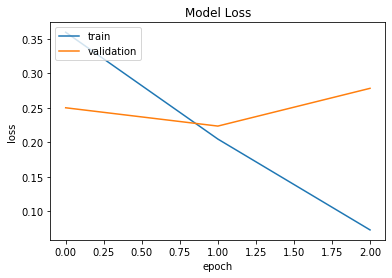

NameError: ignored

In [23]:
model = BERT()
evaluate([model], ["Baseline Bert"], show_plot=True)

We can graph the effectiveness of learning rates by simulating training:

In [0]:
model.find_lr()

This lines up with Google's recommendation of 2e-5



Through an ad hoc search, we determined that the best hyperparameters were:


# Logistic Regression

The runner up to BERT was Logistic Regression, so let's do some hyperparameter search:

First, we'll define a helpful Model and Vectorizer wrapper classes. This is useful because we need to vectorize the text before we can use it in a logistic regression, and the Model class helps bundle the functionality of the vectorizer for easier use.

In [0]:
from typing import List

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


class Vectorizer:

    def __init__(self, pca=True, base_model=TfidfVectorizer(lowercase=True), make_array=False):
        self.base_model = base_model
        self.dimensionality_reducer = None
        self.pca = pca
        self.make_array = make_array

    def fit_transform(self, reviews: List[str]):
        X_train = self.base_model.fit_transform(reviews)
        if self.pca:
            self.dimensionality_reducer = TruncatedSVD(n_components=1000)
            X_train = self.dimensionality_reducer.fit_transform(X_train)
        elif self.make_array:
            X_train = X_train.toarray()
        return X_train

    def transform(self, comments: List[str]):
        if self.pca:
            comments = self.dimensionality_reducer.transform(self.base_model.transform(comments))
        else:
            comments = self.base_model.transform(comments)
            if self.make_array:
                comments = comments.toarray()
        return comments


class Model:

    def __init__(self, vectorizer=Vectorizer(pca=True), model=SVC()):
        self.vectorizer = vectorizer
        self.model = model

    def fit(self, reviews_train: List[str], y_train, show_plot = True, verbose = False):
        X_train = self.vectorizer.fit_transform(reviews_train) if self.vectorizer is not None else reviews_train
        self.model.fit(X_train, y_train)

    def predict(self, reviews_test: List[str]):
        X_test = self.vectorizer.transform(reviews_test) if self.vectorizer is not None else reviews_test
        return np.round(np.array(self.model.predict(X_test)))

    def get_params(self, deep = True):
        return {'model' : self.model, 'vectorizer' : self.vectorizer}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self



In [35]:
from sklearn.linear_model import LogisticRegression

models = []
names = []

for c in [0.25, 0.5, 1, 1.5, 2, 4, 8, 16, 32]:
  for rat in [0, 0.25, 0.5, 0.75, 1]:
    models.append(Model(model=LogisticRegression(C=c, penalty = 'elasticnet', solver='saga', l1_ratio = rat), vectorizer=Vectorizer(pca=False)))
    names.append("Logistic: C: %s, l1_ratio: %s" % (c, rat))

results = evaluate(models, names)

Model: Logistic: C: 0.25, l1_ratio: 0
Accurracy: 0.8254
F1: 0.8224527150701648
Model: Logistic: C: 0.25, l1_ratio: 0.25
Accurracy: 0.8093
F1: 0.806533428020696
Model: Logistic: C: 0.25, l1_ratio: 0.5
Accurracy: 0.7993
F1: 0.7963470319634703
Model: Logistic: C: 0.25, l1_ratio: 0.75
Accurracy: 0.7925
F1: 0.7891045837991665
Model: Logistic: C: 0.25, l1_ratio: 1
Accurracy: 0.7846
F1: 0.7791222313371616
Model: Logistic: C: 0.5, l1_ratio: 0
Accurracy: 0.8327
F1: 0.8294771175211496
Model: Logistic: C: 0.5, l1_ratio: 0.25
Accurracy: 0.8235
F1: 0.8206118507978454
Model: Logistic: C: 0.5, l1_ratio: 0.5
Accurracy: 0.8173
F1: 0.8147622427253371
Model: Logistic: C: 0.5, l1_ratio: 0.75
Accurracy: 0.8141
F1: 0.8113264995432864
Model: Logistic: C: 0.5, l1_ratio: 1
Accurracy: 0.8128
F1: 0.8092520888526594
Model: Logistic: C: 1, l1_ratio: 0
Accurracy: 0.8373
F1: 0.834368319250738
Model: Logistic: C: 1, l1_ratio: 0.25
Accurracy: 0.8341
F1: 0.8314880650076181
Model: Logistic: C: 1, l1_ratio: 0.5
Accurracy

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 2, l1_ratio: 1
Accurracy: 0.832
F1: 0.8304400484457005
Model: Logistic: C: 4, l1_ratio: 0
Accurracy: 0.8404
F1: 0.8385269121813032
Model: Logistic: C: 4, l1_ratio: 0.25
Accurracy: 0.8385
F1: 0.8365550045541948
Model: Logistic: C: 4, l1_ratio: 0.5
Accurracy: 0.8389
F1: 0.8368607594936709
Model: Logistic: C: 4, l1_ratio: 0.75
Accurracy: 0.8347
F1: 0.8325736858097842


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 4, l1_ratio: 1
Accurracy: 0.8295
F1: 0.8279342012312041
Model: Logistic: C: 8, l1_ratio: 0
Accurracy: 0.836
F1: 0.8344771901493742
Model: Logistic: C: 8, l1_ratio: 0.25
Accurracy: 0.8331
F1: 0.8313971108192746
Model: Logistic: C: 8, l1_ratio: 0.5
Accurracy: 0.8311
F1: 0.8295488949439904


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 8, l1_ratio: 0.75
Accurracy: 0.826
F1: 0.824313408723748


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 8, l1_ratio: 1
Accurracy: 0.818
F1: 0.8166431593794076
Model: Logistic: C: 16, l1_ratio: 0
Accurracy: 0.8278
F1: 0.826271186440678


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 16, l1_ratio: 0.25
Accurracy: 0.8253
F1: 0.8238023197175997


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 16, l1_ratio: 0.5
Accurracy: 0.8238
F1: 0.8224863993552287


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 16, l1_ratio: 0.75
Accurracy: 0.8199
F1: 0.8183193785937658


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 16, l1_ratio: 1
Accurracy: 0.8136
F1: 0.8123993558776167


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 32, l1_ratio: 0
Accurracy: 0.8196
F1: 0.8185840707964602


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 32, l1_ratio: 0.25
Accurracy: 0.8196
F1: 0.8183282980866063


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 32, l1_ratio: 0.5
Accurracy: 0.8167
F1: 0.8153520701118163


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 32, l1_ratio: 0.75
Accurracy: 0.8138
F1: 0.8125251711639145


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model: Logistic: C: 32, l1_ratio: 1
Accurracy: 0.81
F1: 0.8086606243705942
